In [47]:
import calendar
from collections import defaultdict
import datetime
import lzma
import ujson
import glob

import pandas as pd
from pandas.tseries.offsets import MonthEnd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns
sns.set()

np.random.seed(0xB1AB)

%matplotlib notebook

In [1]:
from util import read_labeled_output

In [3]:
"""
Don't run these: we used this to get total_month_counts, total_daily_counts, etc

def get_month_counts():
    month_counts = dict()
    for month in range(1, 13):
        file_path = "../data/classified-reddit/blacklists/2018-{:02d}.txt".format(month)
        i = -1
        with open(file_path) as f:
            for i, l in enumerate(f):
                pass
        num_comments = i + 1
        print("{}: {}".format(month, num_comments))
        month_counts[month] = num_comments
    return month_counts


def get_total_month_counts():
    month_counts = dict()
    for month in range(1, 13):
        file_path = "/shared/2/datasets/reddit-dump-all/RC/RC_2018-{:02d}.xz".format(month)
        i = -1
        with lzma.open(file_path, "rt") as f:
            for i, l in enumerate(f):
                if i % 1000000 == 0:
                    print(i)
                pass
        num_comments = i + 1
        month_counts[month] = num_comments
        print("{}: {}".format(month, num_comments))
    return month_counts


def get_total_daily_counts():
    day_counts = defaultdict(int)
    for month in range(1, 13):
        file_path = "/shared/2/datasets/reddit-dump-all/RC/RC_2018-{:02d}.xz".format(month)
        i = -1
        with lzma.open(file_path, "rt") as f:
            for i, l in enumerate(f):
                if i % 1000000 == 0:
                    print(i)
                day = ujson.loads(l)
                day_counts[day['created_utc'] // 86400] += 1
        print("{}: {}".format(month, num_comments))
    print(day_counts)
    return day_counts
    
"""

In [45]:
(year,
 c,
 cs,
 both) = read_labeled_output("./data/condolence-sample-reddit-2018.tsv")

Loading labeled comments from ./data/condolence-sample-reddit-2018.tsv


/opt/anaconda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [6]:
total_month_counts = {1: 91558594,
 2: 86467179,
 3: 96490262,
 4: 98101232,
 5: 100109100,
 6: 100009462,
 7: 108151359,
 8: 107330940,
 9: 104473929,
 10: 112346556,
 11: 112573001,
 12: 121953600}

total_daily_counts = ujson.load(open("./data/auxiliary/daily_counts.json", "r"))

classified_month_counts = {1: 68683789,
 2: 65077111,
 3: 62616542,
 4: 64367203,
 5: 61446372,
 6: 66797890,
 7: 59981093,
 8: 60051313,
 9: 61667939,
 10: 64792670,
 11: 59112604,
 12: 61266010}

classified_daily_counts = pd.concat([pd.Series(ujson.load(open(filename))) for filename in glob.glob("../data/daily-classified-counts/daily_classified_counts_*.json")]).to_dict()


# Proportions by Month

In [7]:
class_month_cts = pd.Series({datetime.datetime(2018, k, 1): v for (k, v) in classified_month_counts.items()})
class_month_cts.index = class_month_cts.index.tz_localize(tz="utc")
joined = pd.concat([cs.groupby(pd.Grouper(freq="M", key="created_utc")).id.count().rename("grief"),
                    c.groupby(pd.Grouper(freq="M", key="created_utc")).id.count().rename("condolence"),
                    class_month_cts.groupby(pd.Grouper(freq="M")).first()],
                   axis=1).rename({0: "total"}, axis=1).reset_index()


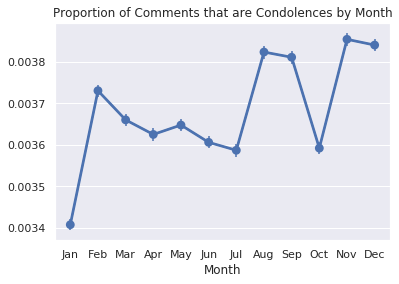

In [9]:
fig = plt.figure()
plt.title("Proportion of Comments that are Condolences by Month")

proportion = joined["condolence"] / joined["total"]
lower = proportion - sm.stats.proportion_confint(joined["condolence"], joined["total"], method="wilson")[0]
upper = sm.stats.proportion_confint(joined["condolence"], joined["total"], method="wilson")[1] - proportion
yerr = [lower, upper]

sns.pointplot(x=joined["created_utc"].dt.strftime("%b"), y=joined["condolence"] / joined["total"], data=joined)
plt.errorbar(x=joined["created_utc"].dt.strftime("%b"), y=joined["condolence"] / joined["total"],
             yerr=yerr)
plt.xlabel("Month")

plt.savefig('./figures/condolence_by_month.pdf')  

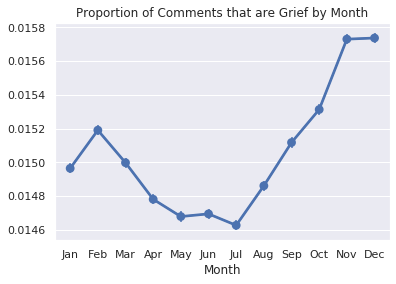

In [10]:
fig = plt.figure()
plt.title("Proportion of Comments that are Grief by Month")

proportion = joined["grief"] / joined["total"]
lower = proportion - sm.stats.proportion_confint(joined["grief"], joined["total"], method="wilson")[0]
upper = sm.stats.proportion_confint(joined["grief"], joined["total"], method="wilson")[1] - proportion
yerr = [lower, upper]

sns.pointplot(x=joined["created_utc"].dt.strftime("%b"), y=joined["grief"] / joined["total"], data=joined)
plt.errorbar(x=joined["created_utc"].dt.strftime("%b"), y=joined["grief"] / joined["total"],
             yerr=yerr)
plt.xlabel("Month")

plt.savefig('./figures/grief_by_month.pdf')  

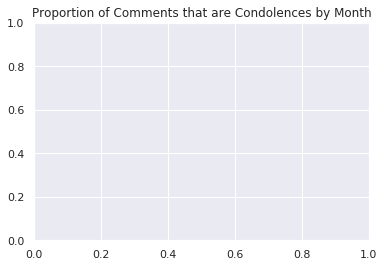

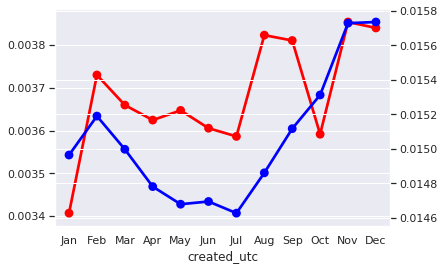

In [11]:
plt.figure()
plt.title("Proportion of Comments that are Condolences by Month")

fig, ax1 = plt.subplots()

proportion = joined["condolence"] / joined["total"]
lower = proportion - sm.stats.proportion_confint(joined["condolence"], joined["total"], method="wilson")[0]
upper = sm.stats.proportion_confint(joined["condolence"], joined["total"], method="wilson")[1] - proportion
yerr = [lower, upper]

sns.pointplot(x=joined["created_utc"].dt.strftime("%b"), y=joined["condolence"] / joined["total"],
              data=joined, ax=ax1, color="red")
# ax1.errorbar(x=joined["created_utc"].dt.strftime("%b"), y=joined["condolence"] / joined["total"],
#              yerr=yerr)
# plt.xlabel("Month")

ax2 = ax1.twinx()

proportion = joined["grief"] / joined["total"]
lower = proportion - sm.stats.proportion_confint(joined["grief"], joined["total"], method="wilson")[0]
upper = sm.stats.proportion_confint(joined["grief"], joined["total"], method="wilson")[1] - proportion
yerr = [lower, upper]

sns.pointplot(x=joined["created_utc"].dt.strftime("%b"), y=joined["grief"] / joined["total"],
              data=joined, ax=ax2, color="blue")
# ax2.errorbar(x=joined["created_utc"].dt.strftime("%b"), y=joined["grief"] / joined["total"],
#              yerr=yerr)
plt.xlabel("Month")


plt.savefig('./figures/condolence_by_month.pdf')  

# Get Representative Sample

This lets us look at daily / weekly counts over the course of the year.

In [12]:
def get_rep_grief_sample():
    monthly_proportions = joined["grief"] / joined["total"]
    sample_counts = np.floor((monthly_proportions / monthly_proportions.max()) * joined["grief"].min()).astype("int")
    new_index = sample_counts.index.map(lambda k: pd.Timestamp("2018-{}".format(k + 1), freq="M", tz="UTC") + MonthEnd(1))
    sample_counts = pd.Series(sample_counts.values, index=new_index)
    grief_by_month = cs.groupby(pd.Grouper(freq="M", key="created_utc"))
    sample = sample_counts.reset_index().apply(lambda x: grief_by_month.get_group(x["index"]).sample(n=x[0]), axis=1)
    sample = pd.concat(sample.values)
    return sample

def get_rep_condolence_sample():
    monthly_proportions = joined["condolence"] / joined["total"]
    sample_counts = np.floor((monthly_proportions / monthly_proportions.max()) * joined["condolence"].min()).astype("int")
    new_index = sample_counts.index.map(lambda k: pd.Timestamp("2018-{}".format(k + 1), freq="M", tz="UTC") + MonthEnd(1))
    sample_counts = pd.Series(sample_counts.values, index=new_index)
    condolence_by_month = c.groupby(pd.Grouper(freq="M", key="created_utc"))
    sample = sample_counts.reset_index().apply(lambda x: condolence_by_month.get_group(x["index"]).sample(n=x[0]), axis=1)
    sample = pd.concat(sample.values)
    return sample

In [13]:
grief_sample = get_rep_grief_sample()
condolence_sample = get_rep_condolence_sample()

# Daily Counts (sample) over 2018

## ASAP Smoothing

In [14]:
import sys
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
import pandas as pd
import json
import numpy.fft
from decimal import Decimal
import math

# ASAP
class Metrics(object):
    def __init__(self, values):
        self.set_values( values )

    def set_values(self, values):
        self.values = values
        self.r = self.k = None

    @property
    def kurtosis(self):
        if self.k is None:
            self.k = scipy.stats.kurtosis(self.values)
        return self.k

    @property
    def roughness(self):
        if self.r is None:
            self.r = np.std(np.diff(self.values))
        return self.r

class ACF(Metrics):
    CORR_THRESH = 0.2
    def __init__(self, values, max_lag=None):
        super(ACF, self).__init__(values)
        if max_lag is None:
            max_lag = len(values) // 5
        self.max_lag = int(max_lag)
        self.max_acf = 0.0

        # Calculate autocorrelation via FFT
        # Demean
        demeaned = values - np.mean(values)
        # Pad data to power of 2 
        l = int(2.0 ** (int(math.log(len(demeaned),2.0)) + 1))
        padded = np.append(demeaned, ([0.0] * (l - len(demeaned))))    
        # FFT and inverse FFT
        F_f = numpy.fft.fft( padded )
        R_t = numpy.fft.ifft( F_f * np.conjugate(F_f) )
        self.correlations = R_t[:max_lag].real / R_t[0].real
        
        # Find autocorrelation peaks 
        self.peaks = []
        if len(self.correlations) >1 :
            positive = self.correlations[1] > self.correlations[0]
            max = 1
            for i in range(2, len(self.correlations)):
                if not positive and self.correlations[i] > self.correlations[i-1]:
                    max = i
                    positive = not positive
                elif positive and self.correlations[i] > self.correlations[max]:
                    max = i
                elif positive and self.correlations[i] < self.correlations[i-1]:
                    if max > 1 and self.correlations[max] > self.CORR_THRESH:
                        self.peaks.append(max)
                        if self.correlations[max] > self.max_acf:
                            self.max_acf = self.correlations[max]
                    positive = not positive
        # If there is no autocorrelation peak within the MAX_WINDOW boundary,
        # try windows from the largest to the smallest 
        if len(self.peaks) <= 1:
            self.peaks = range(2, len(self.correlations))
                    
def moving_average(data, _range):
    ret = np.cumsum(data)
#     print("...", ret[_range:])
    ret[_range:] = ret[_range:] - ret[:-_range]
    return ret[_range - 1:] // _range

def SMA(data, _range, slide):
    ret = moving_average(data, _range)[::slide]
    return list(ret)
                    
def binary_search(head,tail,data,min_obj,orig_kurt,window_size):
    while head <= tail:
        w = int(round((head + tail) / 2.0))
        smoothed = SMA(data,w,1)
        metrics  = Metrics(smoothed)
        if metrics.kurtosis >= orig_kurt:
            if metrics.roughness < min_obj:
                window_size = w
                min_obj = metrics.roughness
            head = w + 1
        else:
            tail = w - 1
    return window_size

def smooth_ASAP(data, max_window=5, resolution=None):
    data = np.array(data)
    # Preaggregate according to resolution
    slide_size = 1
    window_size = 1
    if resolution and len(data) >= 2 * resolution:
        slide_size = len(data) // resolution
        data = SMA(data, slide_size, slide_size)
    acf         = ACF(data, max_lag=len(data) // max_window)
    peaks       = acf.peaks
    orig_kurt   = acf.kurtosis
    min_obj     = acf.roughness
    lb          = 1
    largest_feasible = -1
    tail = len(data) // max_window
    for i in range(len(peaks) - 1, -1, -1):
        w = peaks[i]

        if w < lb or w == 1:
            break
        elif math.sqrt(1 - acf.correlations[w]) * window_size > math.sqrt(1 - acf.correlations[window_size]) * w:
            continue

        smoothed = SMA(data, w, 1)
        metrics = Metrics(smoothed)
        if metrics.roughness < min_obj and metrics.kurtosis >= orig_kurt:
            min_obj = metrics.roughness
            window_size = w
            lb = round( max(w*math.sqrt( (acf.max_acf -1) / (acf.correlations[w]-1) ), lb) )
    if largest_feasible > 0:
        if largest_feasible < len(peaks) - 2:
            tail = peaks[largest_feasible + 1]
        lb = max(lb, peaks[largest_feasible] + 1)

    window_size = binary_search(lb, tail, data, min_obj, orig_kurt, window_size)
    return window_size, slide_size

# Plot time series before and after smoothing
def plot(data, labels, window_size, slide_size):
#     plt.clf()
#     plt.figure()
    data = SMA(data, slide_size, slide_size)
    method_names = ["Original", "Smoothed"]
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    smoothed = SMA(data, window_size, 1)
    smoothed_range = range(int(window_size/2), int(window_size/2) + len(smoothed))
    smoothed_labels = labels[window_size // 2: window_size // 2 + len(smoothed)]
#     ax1.set_xlim(0, len(data))
    ax1.plot(labels, data, linestyle='-', linewidth=1.5)
    ax2.plot(smoothed_labels, smoothed, linestyle='-', linewidth=1.5)
    
    mark_dates = [
#         datetime.datetime(2018, 9, 11)
    ]
    for date in mark_dates:
        ax2.axvline(date, color="red", linewidth=1)
    ax2.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

    fig.autofmt_xdate()
    plt.tight_layout(w_pad=1)
    plt.show()

## Plot

Window Size:  7


/opt/anaconda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


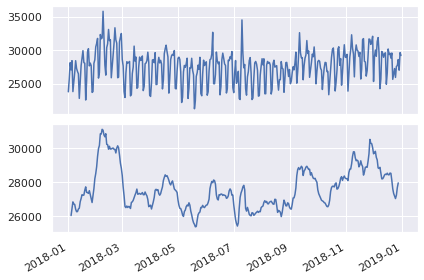

In [15]:
counts = grief_sample[["created_utc"]].groupby(grief_sample.created_utc.dt.date).count()
raw_data = counts.created_utc.to_numpy()
labels = counts.index.to_numpy()
window_size, slide_size = smooth_ASAP(raw_data, resolution=1000)
#window_size, slide_size = smooth_simple(raw_data, resolution=1000)
print("Window Size: ", window_size)
plot(raw_data, labels, window_size, slide_size)

Window Size:  1


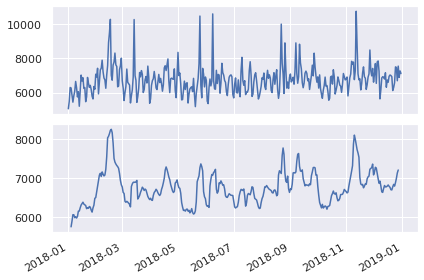

In [16]:
counts = condolence_sample[["created_utc"]].groupby(condolence_sample.created_utc.dt.date).count()
raw_data = counts.created_utc.to_numpy()
labels = counts.index.to_numpy()
window_size, slide_size = smooth_ASAP(raw_data, resolution=1000)
#window_size, slide_size = smooth_simple(raw_data, resolution=1000)
print("Window Size: ", window_size)
plot(raw_data, labels, 7, slide_size)

In [17]:
condolence_by_day = condolence_sample[["created_utc"]].groupby(condolence_sample.created_utc.dt.date)

In [18]:
condolence_by_day.count().idxmax()

created_utc    2018-11-12
dtype: object

In [19]:
condolence_by_day.get_group("2018-8-22").count()

created_utc    9999
dtype: int64

# Proportion By Day

## Plots

In [20]:
class_day_cts = pd.Series({pd.to_datetime(k, utc=True, unit="d"): v for (k, v) in classified_daily_counts.items()})
joined = pd.concat([cs.groupby(pd.Grouper(freq="D", key="created_utc")).id.count().rename("grief"),
                    c.groupby(pd.Grouper(freq="D", key="created_utc")).id.count().rename("condolence"),
                    class_day_cts.groupby(pd.Grouper(freq="D")).first()],
                   axis=1).rename({0: "total"}, axis=1).reset_index()


Text(0.5, 0, 'Day')

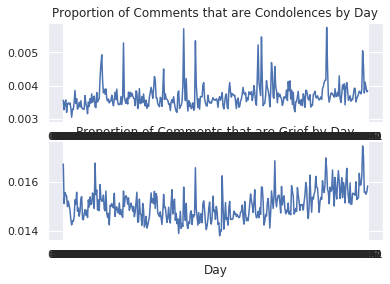

In [21]:
fig = plt.figure()

plt.subplot(211)
plt.title("Proportion of Comments that are Condolences by Day")

proportion = joined["condolence"] / joined["total"]
lower = proportion - sm.stats.proportion_confint(joined["condolence"], joined["total"], method="wilson")[0]
upper = sm.stats.proportion_confint(joined["condolence"], joined["total"], method="wilson")[1] - proportion
yerr = [lower, upper]

sns.lineplot(x=joined["created_utc"].dt.strftime("%m-%d"), y=joined["condolence"] / joined["total"], data=joined)
# plt.errorbar(x=joined["created_utc"].dt.strftime("%m-%d"), y=joined["condolence"] / joined["total"],
#              yerr=yerr)
plt.xlabel("")
plt.subplot(212)
plt.title("Proportion of Comments that are Grief by Day")

proportion = joined["grief"] / joined["total"]
lower = proportion - sm.stats.proportion_confint(joined["grief"], joined["total"], method="wilson")[0]
upper = sm.stats.proportion_confint(joined["grief"], joined["total"], method="wilson")[1] - proportion
yerr = [lower, upper]

sns.lineplot(x=joined["created_utc"].dt.strftime("%m-%d"), y=joined["grief"] / joined["total"], data=joined)
# plt.errorbar(x=joined["created_utc"].dt.strftime("%m-%d"), y=joined["grief"] / joined["total"],
#              yerr=yerr)

plt.xlabel("Day")

In [22]:
import statsmodels.api as sm

In [23]:
proportion.head()

0    0.016736
1    0.015114
2    0.015570
3    0.015486
4    0.015419
dtype: float64

In [24]:
pd.Series((joined["condolence"] / joined["total"]).values, index=joined["created_utc"]).head()

created_utc
2018-01-01 00:00:00+00:00    0.003559
2018-01-02 00:00:00+00:00    0.003271
2018-01-03 00:00:00+00:00    0.003490
2018-01-04 00:00:00+00:00    0.003567
2018-01-05 00:00:00+00:00    0.003194
Freq: D, dtype: float64

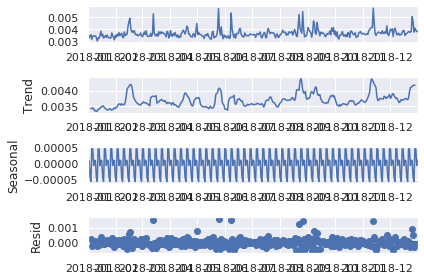

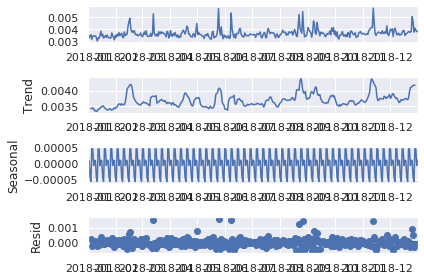

In [25]:
proportion = pd.Series((joined["condolence"] / joined["total"]).values, index=joined["created_utc"])
decomp = sm.tsa.seasonal_decompose(proportion)
decomp.plot()

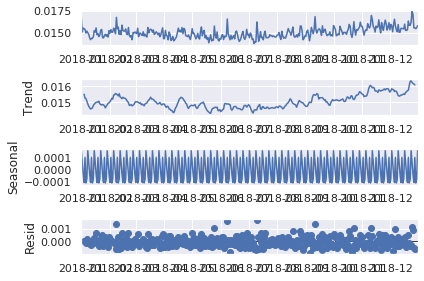

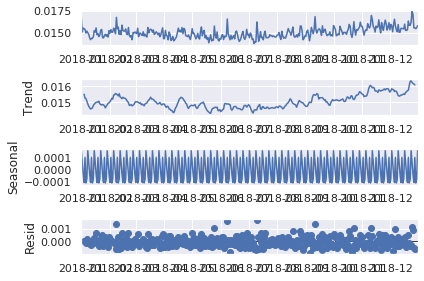

In [26]:
proportion = pd.Series((joined["grief"] / joined["total"]).values, index=joined["created_utc"])
decomp = sm.tsa.seasonal_decompose(proportion)
decomp.plot()

Text(0.5, 0, 'Day')

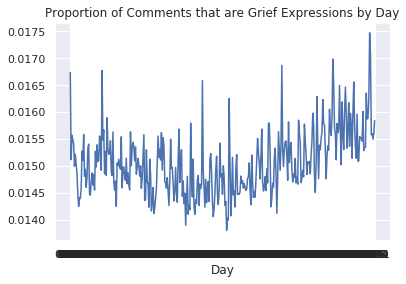

In [27]:
fig = plt.figure()
plt.title("Proportion of Comments that are Grief Expressions by Day")

proportion = joined["grief"] / joined["total"]
lower = proportion - sm.stats.proportion_confint(joined["grief"], joined["total"], method="wilson")[0]
upper = sm.stats.proportion_confint(joined["grief"], joined["total"], method="wilson")[1] - proportion
yerr = [lower, upper]

sns.lineplot(x=joined["created_utc"].dt.strftime("%m-%d"), y=joined["grief"] / joined["total"], data=joined)
# plt.errorbar(x=joined["created_utc"].dt.strftime("%m-%d"), y=joined["grief"] / joined["total"],
#              yerr=yerr)
plt.xlabel("Day")

## Correlation

In [28]:
coef = lambda x, y: np.corrcoef(x, y)[0][1]

In [29]:
coef((joined["condolence"] / joined["total"]), joined["grief"] / joined["total"])

0.47925293367926064

In [30]:
def offset_corr(i):
    return coef((joined["condolence"] / joined["total"]).shift(i).dropna(),
                (joined["grief"] / joined["total"]).shift(-i).dropna())

In [31]:
[offset_corr(i) for i in np.arange(-7, 7)]

[0.04884389814093994,
 0.06703026659301185,
 0.14261380435757748,
 0.129092179465621,
 0.06658319127061643,
 0.07730784232309089,
 0.21563401507948787,
 0.47925293367926064,
 0.2472669229828344,
 0.14382263900830017,
 0.13533185935410066,
 0.13881431625053176,
 0.08264303234445101,
 0.06472473411904626]

# Average Count by Weekday

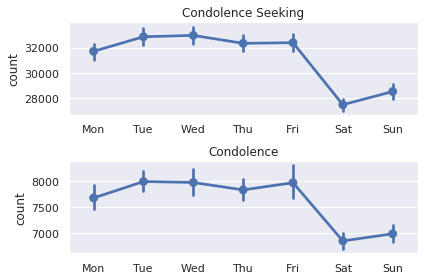

In [32]:
plt.figure()

agg_by_day = cs[["created_utc", "id"]].groupby(cs.created_utc.dt.date,
                                               as_index=False).agg({"id": "count",
                                                                    "created_utc": "first"}).rename({"id": "count"},
                                                                                                    axis=1)
day_of_week = pd.concat([agg_by_day, agg_by_day.created_utc.dt.dayofweek.apply(lambda x: calendar.day_name[x][:3]).rename("day")],
                        axis=1)        
ax = plt.subplot(211)
ax.set_title("Condolence Seeking")
sns.pointplot(x="day", y="count", data=day_of_week)
ax.set_xlabel("")

ax = plt.subplot(212)
agg_by_day = c[["created_utc", "id"]].groupby(c.created_utc.dt.date,
                                               as_index=False).agg({"id": "count",
                                                                    "created_utc": "first"}).rename({"id": "count"},
                                                                                                    axis=1)
day_of_week = pd.concat([agg_by_day, agg_by_day.created_utc.dt.dayofweek.apply(lambda x: calendar.day_name[x][:3]).rename("day")],
                        axis=1)        
ax.set_title("Condolence")
sns.pointplot(x="day", y="count", data=day_of_week)
ax.set_xlabel("")

plt.tight_layout()

plt.savefig('./figures/count_by_weekday.pdf')  



I'd like to adjust for total reddit volume, so I collected the total number of comments per day. It's encoded as UTC days, which I can bring back into a datetime.

In [33]:
daily_counts = pd.Series(index=pd.to_datetime(np.fromiter(total_daily_counts.keys(), dtype=float), utc=True, unit="d"), data=np.fromiter(total_daily_counts.values(), dtype=np.int64))


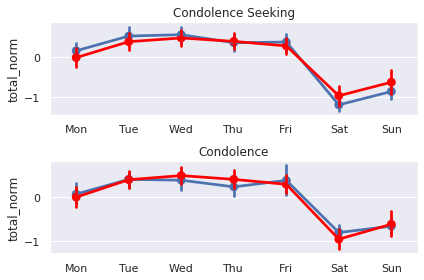

In [34]:
plt.figure()

agg_by_day = cs[["created_utc", "id"]].groupby(cs.created_utc.dt.date,
                                               as_index=False).agg({"id": "count",
                                                                    "created_utc": "first"}).rename({"id": "count"},
                                                                                                    axis=1)
day_of_week = pd.concat([agg_by_day,
                         daily_counts.rename("total").reset_index(drop=True),
                         agg_by_day.created_utc.dt.dayofweek.apply(lambda x: calendar.day_name[x][:3]).rename("day")],
                        axis=1)
# normalize
day_of_week["count_norm"] = (day_of_week["count"] - day_of_week["count"].mean()) / day_of_week["count"].std()
day_of_week["total_norm"] = (day_of_week["total"] - day_of_week["total"].mean()) / (day_of_week["total"].std())
ax = plt.subplot(211)
ax.set_title("Condolence Seeking")
sns.pointplot(x="day", y="count_norm", data=day_of_week)
sns.pointplot(x="day", y="total_norm", data=day_of_week, color="red")
ax.set_xlabel("")

ax = plt.subplot(212)
agg_by_day = c[["created_utc", "id"]].groupby(c.created_utc.dt.date,
                                               as_index=False).agg({"id": "count",
                                                                    "created_utc": "first"}).rename({"id": "count"},
                                                                                                    axis=1)
day_of_week = pd.concat([agg_by_day,
                         daily_counts.rename("total").reset_index(drop=True),
                         agg_by_day.created_utc.dt.dayofweek.apply(lambda x: calendar.day_name[x][:3]).rename("day")],
                        axis=1)     
day_of_week["count_norm"] = (day_of_week["count"] - day_of_week["count"].mean()) / day_of_week["count"].std()
day_of_week["total_norm"] = (day_of_week["total"] - day_of_week["total"].mean()) / (day_of_week["total"].std())
ax.set_title("Condolence")
sns.pointplot(x="day", y="count_norm", data=day_of_week, dodge=True)
sns.pointplot(x="day", y="total_norm", data=day_of_week, color="red", dodge=True)
ax.set_xlabel("")

plt.tight_layout()
plt.savefig('./figures/amount_by_weekday_compare.pdf')  


# Hourly

In [36]:
expectation_comments_by_hour_df = pd.read_csv("../working-dir/parsed/hourly_by_subreddit.csv")

In [37]:
expectation_comments_by_hour_df.head()

,sub,comment_count,num_days,hour
0,openstreetmap,179,113,0
1,HunterXHunter,8745,365,0
2,Goruck,1269,317,0
3,nightvale,388,199,0
4,wholesomegreentext,747,252,0


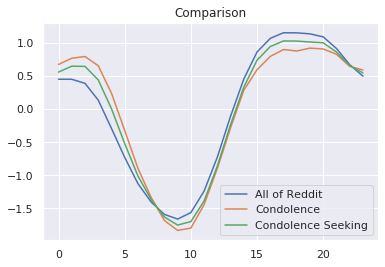

In [38]:
plt.figure()
plt.title("Comparison")

total = expectation_comments_by_hour_df.groupby("hour").sum()
expected_count = total.comment_count / 365
expected_count = (expected_count - expected_count.mean()) / expected_count.std()
plt.plot(total.index, expected_count, label="All of Reddit")

agg_by_day = c[["created_utc", "id"]].groupby(c.created_utc.dt.hour, as_index=False).agg({"id": "count", "created_utc": "first"})
center_count = agg_by_day.groupby(agg_by_day.created_utc.dt.hour).mean().id
center_count = (center_count - center_count.mean()) / center_count.std()
plt.plot(total.index, center_count, label="Condolence")

agg_by_day = cs[["created_utc", "id"]].groupby(cs.created_utc.dt.hour, as_index=False).agg({"id": "count", "created_utc": "first"})
center_count = agg_by_day.groupby(agg_by_day.created_utc.dt.hour).mean().id
center_count = (center_count - center_count.mean()) / center_count.std()
plt.plot(total.index, center_count, label="Condolence Seeking")

plt.legend()

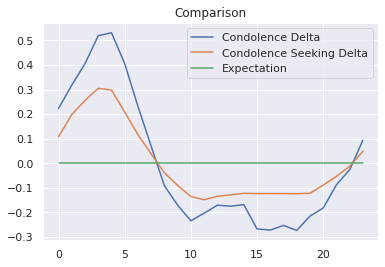

In [39]:
plt.figure()
plt.title("Comparison")

agg_by_day = c[["created_utc", "id"]].groupby(c.created_utc.dt.hour, as_index=False).agg({"id": "count", "created_utc": "first"})
center_count = agg_by_day.groupby(agg_by_day.created_utc.dt.hour).mean().id
center_count = (center_count - center_count.mean()) / center_count.std()

plt.plot(total.index, center_count - expected_count, label="Condolence Delta")

agg_by_day = cs[["created_utc", "id"]].groupby(cs.created_utc.dt.hour, as_index=False).agg({"id": "count", "created_utc": "first"})
center_count = agg_by_day.groupby(agg_by_day.created_utc.dt.hour).mean().id
center_count = (center_count - center_count.mean()) / center_count.std()

plt.plot(total.index, center_count - expected_count, label="Condolence Seeking Delta")

total = expectation_comments_by_hour_df.groupby("hour").sum()
expected_count = total.comment_count / 365
expected_count = (expected_count - expected_count.mean()) / expected_count.std()

plt.plot(total.index, expected_count - expected_count, label="Expectation")

plt.legend()

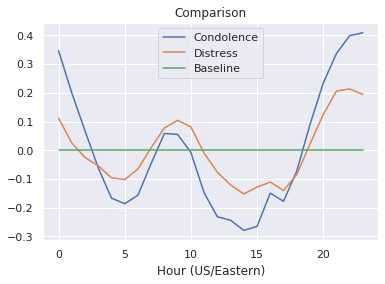

In [40]:
plt.figure()
plt.title("Comparison")

total = expectation_comments_by_hour_df.groupby("hour").sum()
total.index -= 4
total.index %= 24
total = total.sort_index()
expected_count = total.comment_count / 365
expected_count = (expected_count - expected_count.mean()) / expected_count.std()


timezone = "US/Eastern"
agg_by_day = c[["created_utc", "id"]].groupby(c.created_utc.dt.tz_convert(timezone).dt.hour, as_index=False).agg({"id": "count", "created_utc": "first"})
center_count = agg_by_day.groupby(agg_by_day.created_utc.dt.tz_convert(timezone).dt.hour).mean().id
center_count = (center_count - center_count.mean()) / center_count.std()

plt.plot(total.index, center_count - expected_count, label="Condolence")

agg_by_day = cs[["created_utc", "id"]].groupby(cs.created_utc.dt.tz_convert(timezone).dt.hour, as_index=False).agg({"id": "count", "created_utc": "first"})
center_count = agg_by_day.groupby(agg_by_day.created_utc.dt.tz_convert(timezone).dt.hour).mean().id
center_count = (center_count - center_count.mean()) / center_count.std()

plt.plot(total.index, center_count - expected_count, label="Distress")


plt.plot(total.index, expected_count - expected_count, label="Baseline")
plt.xlabel("Hour ({})".format(timezone))
plt.legend()

plt.savefig('./figures/amount_by_hour.pdf')  



# Subreddits

In [42]:
subreddits = pd.read_csv("../working-dir/parsed/10k_by_comments_2018.csv").set_index("subreddit")
present = c.subreddit.unique()

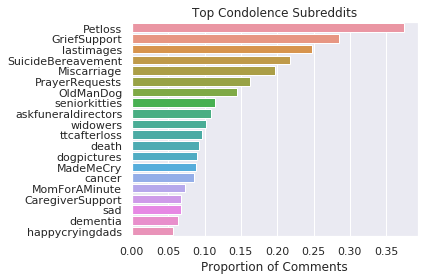

In [43]:
ratios = (c.groupby("subreddit").id.count().reindex(present) / subreddits.reindex(present)['comment_count']).sort_values(ascending=False)
# ratios = (ratios - ratios.min()) / (ratios.max() - ratios.min())
ratios = ratios[:20]

fig, ax = plt.subplots()
ax.set_title("Top Condolence Subreddits")
sns.barplot(y=ratios.index.to_numpy(),
              x=ratios)
# plt.xticks(rotation="vertical")
plt.xlabel("Proportion of Comments")
plt.tight_layout()
plt.savefig('./figures/top_condolence_subs.pdf')  



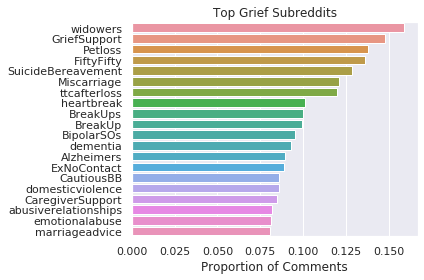

In [44]:
ratios = (cs.groupby("subreddit").id.count().reindex(present) / subreddits.reindex(present)['comment_count']).sort_values(ascending=False)
# ratios = (ratios - ratios.min()) / (ratios.max() - ratios.min())
ratios = ratios[:20]

fig, ax = plt.subplots()
ax.set_title("Top Grief Subreddits")
sns.barplot(y=ratios.index.to_numpy(),
              x=ratios)
# plt.xticks(rotation="vertical")
plt.xlabel("Proportion of Comments")
plt.tight_layout()

plt.savefig('./figures/top_grief_subs.pdf')  

